In [1]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import random
from sklearn.metrics import brier_score_loss

### Wczytanie ramek danych

In [3]:
pd.set_option('display.max_columns', None)
matches = pd.read_csv("data/prepared_data.csv")
matches = matches[matches['round'] > 3]
matches.head(2)
len(matches)

11700

In [4]:
matches = matches[matches["season"] != "2024-2025"]

In [5]:
matches[matches[["home_last5_passes_pct"]].isna().any(axis=1)].head(2)

,season,date,time,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_possession,away_possession,home_lineup,away_lineup,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,league,Unnamed: 0.1,Unnamed

#### Przygotowanie ramki danych ze statystykami z ostatnich meczów

In [6]:
# or 'matches_since' in col or 'overall' in col or 'tiredness' in col or 'h2h' in col
all_stats = matches[[col for col in matches.columns if 'last5' in col or 'outcome' in col or 'matches_since' in col or 'overall' in col or 'tiredness' in col or 'h2h' in col]]
all_stats.columns[all_stats.isna().any()]
all_stats[all_stats.isna().any(axis=1)]

,outcome,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_possession,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_possession,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_k

In [7]:
all_stats.groupby(['outcome']).mean()

,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_possession,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_possession,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,awa

In [8]:
all_stats.head(2)

,outcome,home_last5_matches_played,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_goals_conceded,home_last5_possession,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_tackles,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_completed_medium,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenges,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_tackles_interceptions,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_matches_played,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_goals_conceded,away_last5_possession,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_xg,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_k

In [9]:
all_stats = all_stats.drop(columns = ["home_last5_possession", "away_last5_possession"])

In [10]:
all_stats = all_stats[~all_stats.isna().any(axis=1)]

### Feature selection na bazie regresji logistycznej

In [11]:
X = all_stats.drop(columns=["outcome"])
y = all_stats["outcome"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
log_reg.fit(X_train, y_train)
model = SelectFromModel(log_reg, prefit=True)
selected_features = X.columns[model.get_support()].tolist()
print("Selected Features based on Logistic Regression:")
print(selected_features)
X_selected = model.transform(X_scaled)

Selected Features based on Logistic Regression:
['home_last5_wins', 'home_last5_draws', 'home_last5_defeats', 'home_last5_goal_difference', 'home_last5_minutes', 'home_last5_goals', 'home_last5_assists', 'home_last5_pens_made', 'home_last5_pens_att', 'home_last5_shots', 'home_last5_shots_on_target', 'home_last5_cards_yellow', 'home_last5_cards_red', 'home_last5_touches', 'home_last5_interceptions', 'home_last5_blocks', 'home_last5_xg', 'home_last5_npxg', 'home_last5_xg_assist', 'home_last5_sca', 'home_last5_gca', 'home_last5_passes_completed', 'home_last5_passes', 'home_last5_passes_pct', 'home_last5_progressive_passes', 'home_last5_carries', 'home_last5_progressive_carries', 'home_last5_take_ons_won', 'home_last5_passes_total_distance', 'home_last5_passes_progressive_distance', 'home_last5_passes_completed_short', 'home_last5_passes_short', 'home_last5_passes_pct_short', 'home_last5_passes_medium', 'home_last5_passes_pct_medium', 'home_last5_passes_completed_long', 'home_last5_passes_

#### Zapis wybranych zmiennych oraz scalera do plików

In [ ]:
# import joblib
# import json
# with open("outcome_features.json", "w", encoding="utf-8") as f:
#     json.dump(selected_features, f)
# joblib.dump(scaler, "outcome_scaler.pkl")

['outcome_scaler.pkl']

In [12]:
all_stats =  pd.DataFrame(X_selected, columns=selected_features)
all_stats["outcome"] = y.reset_index(drop=True)

In [235]:
all_stats.groupby(['outcome']).mean()

,home_last5_wins,home_last5_draws,home_last5_defeats,home_last5_goal_difference,home_last5_minutes,home_last5_goals,home_last5_assists,home_last5_pens_made,home_last5_pens_att,home_last5_shots,home_last5_shots_on_target,home_last5_cards_yellow,home_last5_cards_red,home_last5_touches,home_last5_interceptions,home_last5_blocks,home_last5_xg,home_last5_npxg,home_last5_xg_assist,home_last5_sca,home_last5_gca,home_last5_passes_completed,home_last5_passes,home_last5_passes_pct,home_last5_progressive_passes,home_last5_carries,home_last5_progressive_carries,home_last5_take_ons_won,home_last5_passes_total_distance,home_last5_passes_progressive_distance,home_last5_passes_completed_short,home_last5_passes_short,home_last5_passes_pct_short,home_last5_passes_medium,home_last5_passes_pct_medium,home_last5_passes_completed_long,home_last5_passes_long,home_last5_passes_pct_long,home_last5_pass_xa,home_last5_assisted_shots,home_last5_passes_into_final_third,home_last5_passes_into_penalty_area,home_last5_crosses_into_penalty_area,home_last5_passes_live,home_last5_passes_dead,home_last5_passes_free_kicks,home_last5_through_balls,home_last5_passes_switches,home_last5_crosses,home_last5_throw_ins,home_last5_corner_kicks,home_last5_corner_kicks_in,home_last5_corner_kicks_out,home_last5_corner_kicks_straight,home_last5_passes_offsides,home_last5_passes_blocked,home_last5_tackles_won,home_last5_tackles_def_3rd,home_last5_tackles_mid_3rd,home_last5_tackles_att_3rd,home_last5_challenge_tackles,home_last5_challenge_tackles_pct,home_last5_challenges_lost,home_last5_blocked_shots,home_last5_blocked_passes,home_last5_clearances,home_last5_errors,home_last5_touches_def_pen_area,home_last5_touches_def_3rd,home_last5_touches_mid_3rd,home_last5_touches_att_3rd,home_last5_touches_att_pen_area,home_last5_touches_live_ball,home_last5_take_ons_won_pct,home_last5_take_ons_tackled,home_last5_take_ons_tackled_pct,home_last5_carries_distance,home_last5_carries_progressive_distance,home_last5_carries_into_final_third,home_last5_carries_into_penalty_area,home_last5_miscontrols,home_last5_dispossessed,home_last5_passes_received,home_last5_progressive_passes_received,home_last5_cards_yellow_red,home_last5_fouls,home_last5_fouled,home_last5_offsides,home_last5_pens_won,home_last5_pens_conceded,home_last5_own_goals,home_last5_ball_recoveries,home_last5_aerials_won,home_last5_aerials_lost,home_last5_aerials_won_pct,home_last5_points,away_last5_wins,away_last5_draws,away_last5_defeats,away_last5_goal_difference,away_last5_minutes,away_last5_goals,away_last5_assists,away_last5_pens_made,away_last5_pens_att,away_last5_shots,away_last5_shots_on_target,away_last5_cards_yellow,away_last5_cards_red,away_last5_touches,away_last5_tackles,away_last5_interceptions,away_last5_blocks,away_last5_npxg,away_last5_xg_assist,away_last5_sca,away_last5_gca,away_last5_passes_completed,away_last5_passes,away_last5_passes_pct,away_last5_progressive_passes,away_last5_carries,away_last5_progressive_carries,away_last5_take_ons,away_last5_take_ons_won,away_last5_passes_total_distance,away_last5_passes_progressive_distance,away_last5_passes_completed_short,away_last5_passes_short,away_last5_passes_pct_short,away_last5_passes_completed_medium,away_last5_passes_medium,away_last5_passes_pct_medium,away_last5_passes_completed_long,away_last5_passes_long,away_last5_passes_pct_long,away_last5_pass_xa,away_last5_assisted_shots,away_last5_passes_into_final_third,away_last5_passes_into_penalty_area,away_last5_crosses_into_penalty_area,away_last5_passes_live,away_last5_passes_dead,away_last5_passes_free_kicks,away_last5_through_balls,away_last5_passes_switches,away_last5_crosses,away_last5_throw_ins,away_last5_corner_kicks,away_last5_corner_kicks_in,away_last5_corner_kicks_out,away_last5_corner_kicks_straight,away_last5_passes_offsides,away_last5_passes_blocked,away_last5_tackles_won,away_last5_tackles_def_3rd,away_last5_tackles_mid_3rd,away_last5_tackles_att_3rd,away_last5_challenge_tackles,away_last5_challenge

#### Wczytywanie danych do torcha

In [240]:
class FootballDataset(Dataset):
    def __init__(self, agg_stats):
        self.agg_stats = agg_stats.drop('outcome', axis=1).values  # Convert to numpy array
        self.labels = agg_stats['outcome'].values  # Convert to numpy array
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return features and labels as tensors
        features = torch.tensor(self.agg_stats[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, labels

In [241]:
train_df, test_df = train_test_split(all_stats, test_size=0.4, random_state=42)
dataset = FootballDataset(train_df)
test_dataset = FootballDataset(test_df)
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

#### Prosta sieć neuronowa z 3 warstwami

In [244]:
class FootballMatchPredictorOutcome(nn.Module):
    def __init__(self, input_agg_stats_size, hidden_size=128):
        super(FootballMatchPredictorOutcome, self).__init__()
        
        self.agg_stats_fc = nn.Sequential(
            nn.Linear(input_agg_stats_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        combined_input_size = hidden_size
        self.fc_combined = nn.Sequential(
            nn.Linear(combined_input_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 3),  # Output: 3 probabilities (hom win/draw/away win)
        )

    def forward(self, agg_stats):

        agg_stats_out = self.agg_stats_fc(agg_stats)

        output = self.fc_combined(agg_stats_out)
        
        return F.softmax(output, dim=1)

#### Narazie najlepsza loss function - która gwarantuje, że prawdopodbieństwo remisów nie jest zbyt małe jak w przypadku innych loss functions

In [334]:
def weighted_cross_entropy_loss(predictions, targets):
    weight_matrix = torch.tensor([
    [1.0, 2.0, 2.0],  # True label is draw (bigger penalty for home/away win predictions)
    [1.0, 1.0, 2.0],  # True label is home win
    [1.0, 2.0, 1.0]   # True label is away win
    ])

    predictions_probs = F.softmax(predictions, dim=1)
    
    one_hot_targets = F.one_hot(targets, num_classes=3).float()

    smoothed_targets = one_hot_targets.clone()
    for i, target in enumerate(targets):
        if target == 0:
            smoothed_targets[i] = torch.tensor([0.76, 0.16, 0.08])
        elif target == 1:
            smoothed_targets[i] = torch.tensor([0.23, 0.64, 0.13])
        elif target == 2:
            smoothed_targets[i] = torch.tensor([0.21, 0.11, 0.68])
    

    loss_per_class = -smoothed_targets * torch.log(predictions_probs)
    # Weight the loss based on the distance between predicted and true class
    # For each true class, apply the corresponding row of the weight matrix
    weights = weight_matrix[targets]
    weighted_loss = loss_per_class * weights

    return weighted_loss.sum(dim=1).mean()


In [335]:
def brier_score_loss(predictions, targets):
    predictions_probs = F.softmax(predictions, dim=1)
    one_hot_targets = F.one_hot(targets, num_classes=3).float()
    loss_per_class = (predictions_probs - one_hot_targets) ** 2
    return loss_per_class.sum(dim=1).mean()

### Trenowanie modelu

In [336]:
model = FootballMatchPredictorOutcome(267)

criterion = weighted_cross_entropy_loss
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.0007)


num_epochs = 3 
batch_size = 64 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
# torch.save(model, 'football_match_predictor_v1.pth')

Epoch 1/3: 100%|██████████| 1725/1725 [00:08<00:00, 212.09it/s]


Epoch [1/3], Loss: 1.2537


Epoch 2/3: 100%|██████████| 1725/1725 [00:08<00:00, 199.28it/s]


Epoch [2/3], Loss: 1.2485


Epoch 3/3: 100%|██████████| 1725/1725 [00:07<00:00, 220.46it/s]

Epoch [3/3], Loss: 1.2477


### Ocena modelu

In [346]:
model.eval()


with torch.no_grad():
    predictions = []
    probabilities=[]
    actuals = []

    for inputs, targets in test_dataloader:
        
        # Get model outputs
        outputs = model(inputs)  # Shape will be [batch_size, 3]
        
        _, predicted_classes = torch.max(outputs, dim=1)
        
        probabilities.extend(outputs)
        predictions.extend(predicted_classes.cpu().numpy())
        actuals.extend(targets.numpy())

print("Predictions:", probabilities)
print("Predictions:", predictions)
print("Actuals:    ", actuals)

accuracy = (np.array(predictions) == np.array(actuals)).mean()
print(f'Accuracy: {accuracy:.4f}')

conf_matrix = confusion_matrix(actuals, predictions)
print("Confusion Matrix:\n", conf_matrix)

probabilities = torch.stack(probabilities).numpy()
bin_edges = np.arange(0, 1.1, 0.1)
home_win_probs = probabilities[:, 1]
away_win_probs = probabilities[:, 2]
draw_probs = probabilities[:, 0]
df = pd.DataFrame({
    'home_win_prob': home_win_probs,
    'away_win_prob': away_win_probs,
    'draw_prob': draw_probs,
    'actual': actuals
})
df['prob_bin1'] = pd.cut(df['home_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin2'] = pd.cut(df['away_win_prob'], bins=bin_edges, labels=bin_edges[:-1])
df['prob_bin0'] = pd.cut(df['draw_prob'], bins=bin_edges, labels=bin_edges[:-1])
bin_results0 = df.groupby('prob_bin0', observed=False).apply(lambda x: (x['actual'] == 0).mean(), include_groups=False)
bin_results1 = df.groupby('prob_bin1', observed=False).apply(lambda x: (x['actual'] == 1).mean(), include_groups=False)
bin_results2 = df.groupby('prob_bin2', observed=False).apply(lambda x: (x['actual'] == 2).mean(), include_groups=False)
comparison = pd.DataFrame({
    'Expected Probability of Home Win': (bin_results1.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Home Win %': bin_results1.values * 100,  # Convert to percentage
    'Expected Probability of Away Win': (bin_results2.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Away Win %': bin_results2.values * 100,  # Convert to percentage
    'Expected Probability of Draw': (bin_results0.index.astype(float) + 0.05) *100,  # Midpoint of each bin
    'Observed Draw %': bin_results0.values * 100  # Convert to percentage
})
comparison

Predictions: [tensor([0.3045, 0.4409, 0.2546]), tensor([0.2934, 0.2810, 0.4257]), tensor([0.3125, 0.4038, 0.2837]), tensor([0.2889, 0.5478, 0.1633]), tensor([0.3071, 0.3375, 0.3553]), tensor([0.2949, 0.5265, 0.1785]), tensor([0.2638, 0.2802, 0.4559]), tensor([0.3132, 0.3939, 0.2929]), tensor([0.3130, 0.3205, 0.3665]), tensor([0.3089, 0.4739, 0.2172]), tensor([0.3025, 0.3629, 0.3346]), tensor([0.2213, 0.1770, 0.6017]), tensor([0.2097, 0.7241, 0.0663]), tensor([0.2826, 0.5654, 0.1520]), tensor([0.2995, 0.5094, 0.1911]), tensor([0.3062, 0.3425, 0.3513]), tensor([0.2540, 0.5237, 0.2223]), tensor([0.3142, 0.4440, 0.2418]), tensor([0.2366, 0.2202, 0.5432]), tensor([0.3025, 0.3584, 0.3391]), tensor([0.2897, 0.3360, 0.3744]), tensor([0.3198, 0.4439, 0.2362]), tensor([0.2366, 0.6822, 0.0812]), tensor([0.3161, 0.4266, 0.2573]), tensor([0.3188, 0.4275, 0.2537]), tensor([0.1520, 0.8173, 0.0307]), tensor([0.1939, 0.1462, 0.6599]), tensor([0.2755, 0.5364, 0.1881]), tensor([0.3098, 0.3152, 0.3749]), 

,Expected Probability of Home Win,Observed Home Win %,Expected Probability of Away Win,Observed Away Win %,Expected Probability of Draw,Observed Draw %
0,5.0,4.347826,5.0,9.353741,5.0,0.000000
1,15.0,15.733333,15.0,16.441006,15.0,15.889831
2,25.0,25.036390,25.0,25.671141,25.0,24.784078
3,35.0,34.727503,35.0,36.209553,35.0,30.452675
4,45.0,43.392690,45.0,45.252525,45.0,NaN
5,55.0,57.657658,55.0,54.189944,55.0,NaN
6,65.0,67.151767,65.0,64.734300,65.0,NaN
7,75.0,72.363636,75.0,68.000000,75.0,NaN
8,85.0,87.704918,85.0,100.000000,85.0,NaN
9,95.0,100.000000,95.0,NaN,95.0,NaN


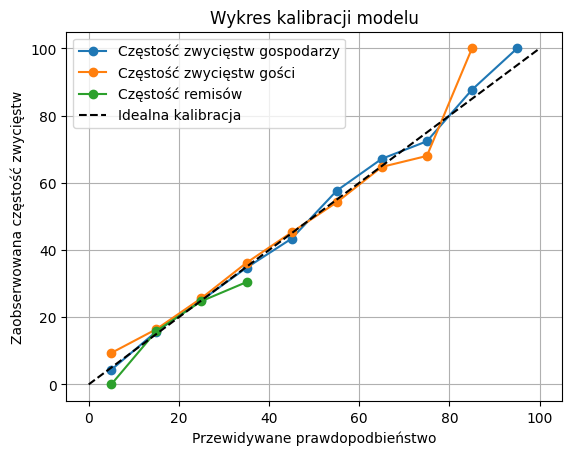

In [338]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values1 = bin_results1.values * 100
values0 = bin_results0.values * 100
values2 = bin_results2.values * 100

plt.plot(centers, values1, "o-", label="Częstość zwycięstw gospodarzy")
plt.plot(centers, values2, "o-", label="Częstość zwycięstw gości")
plt.plot(centers, values0, "o-", label="Częstość remisów")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji modelu")
plt.legend()
plt.grid()
plt.show()

## Nowe ładne obliczenia

In [342]:
df = pd.DataFrame({
    'home_win_prob': home_win_probs,
    'away_win_prob': away_win_probs,
    'draw_prob': draw_probs,
    'actual': actuals
})

bins = np.linspace(0, 1, 11)
df['bin_home_win'] = pd.cut(df['home_win_prob'], bins=bins, labels=bins[:-1])
df['bin_draw'] = pd.cut(df['draw_prob'], bins=bins, labels=bins[:-1])
df['bin_away_win'] = pd.cut(df['away_win_prob'], bins=bins, labels=bins[:-1])
calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['home_win_prob'].mean(),
        'observed_freq': (x['actual'] == 1).mean(),
        'count': x['home_win_prob'].count(),
        'difference' : - x['home_win_prob'].mean() + (x['actual'] == 1).mean()
    })
).reset_index()
calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['draw_prob'].mean(),
        'observed_freq': (x['actual'] == 0).mean(),
        'count': x['home_win_prob'].count(),
        'difference': - x['draw_prob'].mean() + (x['actual'] == 0).mean()
    })
).reset_index()
calibration_away_win = df.groupby('bin_away_win', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['away_win_prob'].mean(),
        'observed_freq': (x['actual'] == 2).mean(),
        'count': x['home_win_prob'].count(),
        'difference': - x['away_win_prob'].mean() + (x['actual'] == 2).mean()
    })
).reset_index()

def mask_low_count(df, bin_col):
    for col in df.columns:
        if col != bin_col and col != 'count':
            df.loc[df['count'] < 10, col] = None
    return df

calibration_home_win = mask_low_count(calibration_home_win, 'bin_home_win')
calibration_draw = mask_low_count(calibration_draw, 'bin_draw')
calibration_away_win = mask_low_count(calibration_away_win, 'bin_away_win')

df

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_15052\1445841440.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_15052\1445841440.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).a

,home_win_prob,away_win_prob,draw_prob,actual,bin_home_win,bin_draw,bin_away_win
0,0.440912,0.254620,0.304468,1,0.4,0.3,0.2
1,0.280965,0.425669,0.293365,1,0.2,0.2,0.4
2,0.403752,0.283724,0.312524,1,0.4,0.3,0.2
3,0.547764,0.163307,0.288929,0,0.5,0.2,0.1
4,0.337543,0.355321,0.307136,0,0.3,0.3,0.3
...,...,...,...,...,...,...,...
4595,0.201145,0.564679,0.234176,1,0.2,0.2,0.5
4596,0.301306,0.415286,0.283408,2,0.3,0.2,0.4
4597,0.411709,0.268971,0.319320,1,0.4,0.3,0.2
4598,0.377844,0.323573,0.298583,1,0.3,0.2,0.3


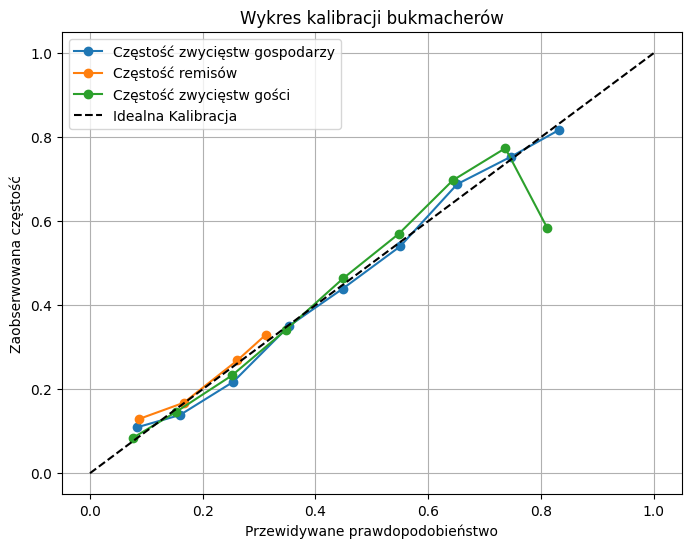

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(calibration_home_win['avg_pred_prob'], calibration_home_win['observed_freq'], marker='o', label="Częstość zwycięstw gospodarzy")
plt.plot(calibration_draw['avg_pred_prob'], calibration_draw['observed_freq'], marker='o', label="Częstość remisów")
plt.plot(calibration_away_win['avg_pred_prob'], calibration_away_win['observed_freq'], marker='o', label="Częstość zwycięstw gości")
plt.plot([0, 1], [0, 1], 'k--', label="Idealna Kalibracja")
plt.title("Wykres kalibracji bukmacherów")
plt.xlabel("Przewidywane prawdopodobieństwo")
plt.ylabel("Zaobserwowana częstość")
plt.legend()
plt.grid()
plt.show()

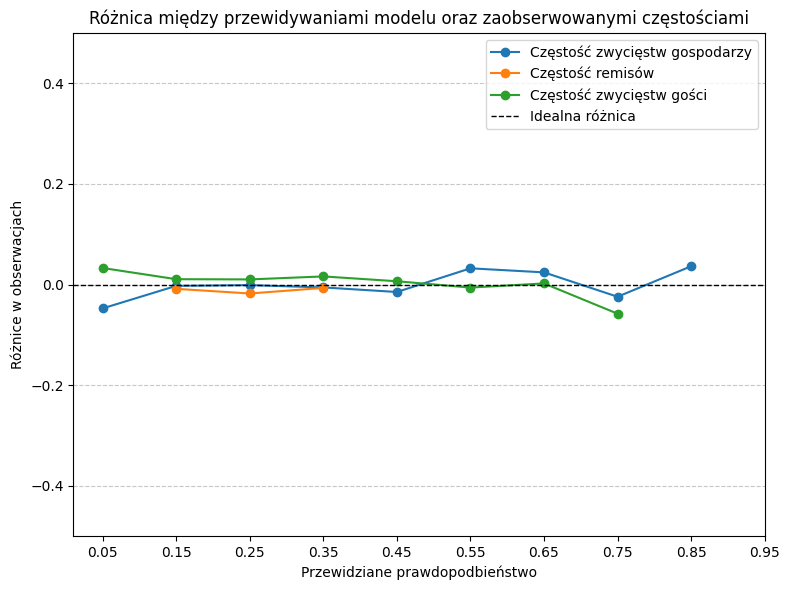

In [344]:
plt.figure(figsize=(8, 6))
bar_width = 0.03
plt.plot([float(x) + 0.05 for x in calibration_home_win["bin_home_win"]], calibration_home_win["difference"], marker="o", label="Częstość zwycięstw gospodarzy")
plt.plot([float(x) + 0.05 for x in calibration_draw["bin_draw"]], calibration_draw["difference"], marker="o", label="Częstość remisów")
plt.plot([float(x) + 0.05 for x in calibration_away_win["bin_away_win"]], calibration_away_win["difference"], marker="o", label="Częstość zwycięstw gości")
plt.axhline(0, color='k', linestyle='--', linewidth=1, label="Idealna różnica")
plt.xlabel("Przewidziane prawdopodbieństwo")
plt.ylabel("Różnice w obserwacjach")
plt.title("Różnica między przewidywaniami modelu oraz zaobserwowanymi częstościami")
plt.xticks([float(x) + 0.05 for x in calibration_home_win["bin_home_win"]])
plt.ylim(-0.5, 0.5)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

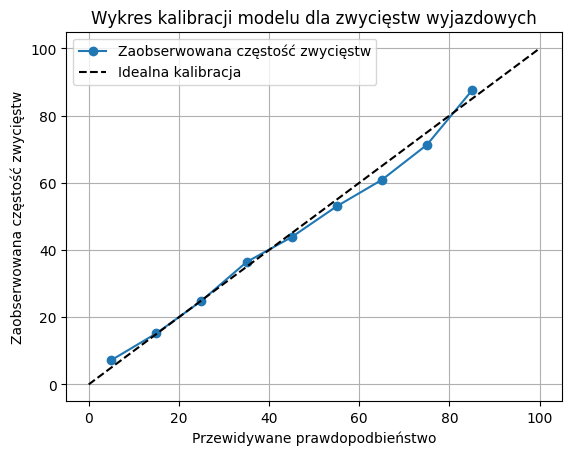

In [189]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results2.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji modelu dla zwycięstw wyjazdowych")
plt.legend()
plt.grid()
plt.show()

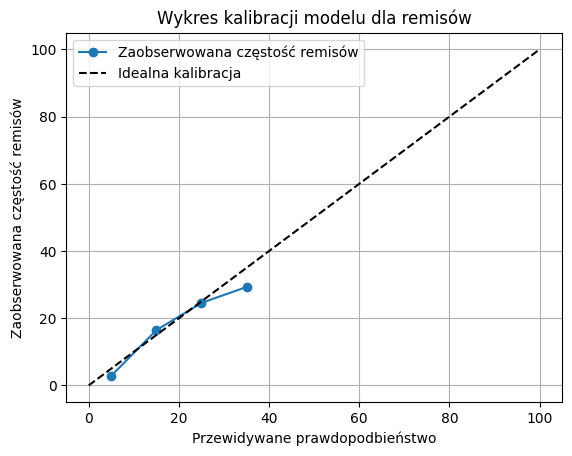

In [190]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results0.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość remisów")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość remisów")
plt.title("Wykres kalibracji modelu dla remisów")
plt.legend()
plt.grid()
plt.show()

### Losowanie wyników - nie działa

In [191]:
random_probs_outcome = []
for probs in probabilities:
    random_probs_outcome.append(random.choices([0, 1, 2], weights=probs, k=1)[0])
accuracy = (np.array(random_probs_outcome) == np.array(actuals)).mean()
print("Predictions:", random_probs_outcome)
print("Actuals:    ", actuals)
print(f'Accuracy: {accuracy:.4f}')
conf_matrix = confusion_matrix(actuals, random_probs_outcome)
print("Confusion Matrix:\n", conf_matrix)

Predictions: [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 0, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 1, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0, 2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1,

### Sprawdzenie z danymi bukmacherów

In [18]:
odds_23_24 = pd.read_csv("data/E0_23-24.csv")
odds_22_23 = pd.read_csv("data/E0_22-23.csv")
odds_21_22 = pd.read_csv("data/E0_21-22.csv")
odds_20_21 = pd.read_csv("data/E0_20-21.csv")
odds_19_20 = pd.read_csv("data/E0_19-20.csv")
odds_18_19 = pd.read_csv("data/E0_18-19.csv")
odds_17_18 = pd.read_csv("data/E0_17-18.csv")
odds = pd.concat([odds_23_24, odds_22_23, odds_21_22, odds_20_21, odds_19_20, odds_18_19], ignore_index=True)
odds = pd.read_csv("odds.csv")

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_42000\2495597284.py:9: DtypeWarning: Columns (153) have mixed types. Specify dtype option on import or set low_memory=False.
  odds = pd.read_csv("odds.csv")


#### Old team mapping - it can be done using fuzzy word similarity like in other models

In [14]:
team_name_mapping = {
    'Burnley': 'Burnley',
    'Arsenal': 'Arsenal',
    'Bournemouth': 'Bournemouth',
    'Brighton': 'Brighton & Hove Albion',
    'Everton': 'Everton',
    'Sheffield United': 'Sheffield United',
    'Newcastle': 'Newcastle United',
    'Brentford': 'Brentford',
    'Chelsea': 'Chelsea',
    'Man United': 'Manchester United',
    "Nott'm Forest": 'Nottingham Forest',
    'Fulham': 'Fulham',
    'Liverpool': 'Liverpool',
    'Wolves': 'Wolverhampton Wanderers',
    'Tottenham': 'Tottenham Hotspur',
    'Man City': 'Manchester City',
    'Aston Villa': 'Aston Villa',
    'West Ham': 'West Ham United',
    'Crystal Palace': 'Crystal Palace',
    'Luton': 'Luton Town',
    'Leeds': 'Leeds United',
    'Leicester': 'Leicester City',
    'Southampton': 'Southampton',
    'Watford': 'Watford',
    'Norwich': 'Norwich City',
    'West Brom': 'West Bromwich Albion',
    'Huddersfield': 'Huddersfield Town',
    'Cardiff': 'Cardiff City'
}

odds['HomeTeam'] = odds['HomeTeam'].map(team_name_mapping)
odds['AwayTeam'] = odds['AwayTeam'].map(team_name_mapping)

KeyError: 'HomeTeam'

In [19]:
odds['Date'] = pd.to_datetime(odds['Date'], format='%d/%m/%Y')
matches['date'] = pd.to_datetime(matches['date'])
odds = odds[["Date", "home_team", "away_team", "B365H", "B365D", "B365A"]]
odds.rename(columns={
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team'
}, inplace=True)

In [20]:
merged_df = pd.merge(
    matches,
    odds,
    how='inner',
    left_on=['home_team', 'away_team', 'date'],
    right_on=['home_team', 'away_team', 'Date']
)
merged_df.drop(columns=['Date'], inplace=True)
merged_df.head(2)

,season,date,time,round,attendance_value,referee,home_manager,away_manager,home_captain,away_captain,formation_home,formation_away,home_possession,away_possession,home_lineup,away_lineup,home_team,away_team,home_minutes,home_goals,home_assists,home_pens_made,home_pens_att,home_shots,home_shots_on_target,home_cards_yellow,home_cards_red,home_touches,home_tackles,home_interceptions,home_blocks,home_xg,home_npxg,home_xg_assist,home_sca,home_gca,home_passes_completed,home_passes,home_passes_pct,home_progressive_passes,home_carries,home_progressive_carries,home_take_ons,home_take_ons_won,home_passes_total_distance,home_passes_progressive_distance,home_passes_completed_short,home_passes_short,home_passes_pct_short,home_passes_completed_medium,home_passes_medium,home_passes_pct_medium,home_passes_completed_long,home_passes_long,home_passes_pct_long,home_pass_xa,home_assisted_shots,home_passes_into_final_third,home_passes_into_penalty_area,home_crosses_into_penalty_area,home_passes_live,home_passes_dead,home_passes_free_kicks,home_through_balls,home_passes_switches,home_crosses,home_throw_ins,home_corner_kicks,home_corner_kicks_in,home_corner_kicks_out,home_corner_kicks_straight,home_passes_offsides,home_passes_blocked,home_tackles_won,home_tackles_def_3rd,home_tackles_mid_3rd,home_tackles_att_3rd,home_challenge_tackles,home_challenges,home_challenge_tackles_pct,home_challenges_lost,home_blocked_shots,home_blocked_passes,home_tackles_interceptions,home_clearances,home_errors,home_touches_def_pen_area,home_touches_def_3rd,home_touches_mid_3rd,home_touches_att_3rd,home_touches_att_pen_area,home_touches_live_ball,home_take_ons_won_pct,home_take_ons_tackled,home_take_ons_tackled_pct,home_carries_distance,home_carries_progressive_distance,home_carries_into_final_third,home_carries_into_penalty_area,home_miscontrols,home_dispossessed,home_passes_received,home_progressive_passes_received,home_cards_yellow_red,home_fouls,home_fouled,home_offsides,home_pens_won,home_pens_conceded,home_own_goals,home_ball_recoveries,home_aerials_won,home_aerials_lost,home_aerials_won_pct,away_minutes,away_goals,away_assists,away_pens_made,away_pens_att,away_shots,away_shots_on_target,away_cards_yellow,away_cards_red,away_touches,away_tackles,away_interceptions,away_blocks,away_xg,away_npxg,away_xg_assist,away_sca,away_gca,away_passes_completed,away_passes,away_passes_pct,away_progressive_passes,away_carries,away_progressive_carries,away_take_ons,away_take_ons_won,away_passes_total_distance,away_passes_progressive_distance,away_passes_completed_short,away_passes_short,away_passes_pct_short,away_passes_completed_medium,away_passes_medium,away_passes_pct_medium,away_passes_completed_long,away_passes_long,away_passes_pct_long,away_pass_xa,away_assisted_shots,away_passes_into_final_third,away_passes_into_penalty_area,away_crosses_into_penalty_area,away_passes_live,away_passes_dead,away_passes_free_kicks,away_through_balls,away_passes_switches,away_crosses,away_throw_ins,away_corner_kicks,away_corner_kicks_in,away_corner_kicks_out,away_corner_kicks_straight,away_passes_offsides,away_passes_blocked,away_tackles_won,away_tackles_def_3rd,away_tackles_mid_3rd,away_tackles_att_3rd,away_challenge_tackles,away_challenges,away_challenge_tackles_pct,away_challenges_lost,away_blocked_shots,away_blocked_passes,away_tackles_interceptions,away_clearances,away_errors,away_touches_def_pen_area,away_touches_def_3rd,away_touches_mid_3rd,away_touches_att_3rd,away_touches_att_pen_area,away_touches_live_ball,away_take_ons_won_pct,away_take_ons_tackled,away_take_ons_tackled_pct,away_carries_distance,away_carries_progressive_distance,away_carries_into_final_third,away_carries_into_penalty_area,away_miscontrols,away_dispossessed,away_passes_received,away_progressive_passes_received,away_cards_yellow_red,away_fouls,away_fouled,away_offsides,away_pens_won,away_pens_conceded,away_own_goals,away_ball_recoveries,away_aerials_won,away_aerials_lost,away_aerials_won_pct,league,Unnamed: 0.1,Unnamed

In [21]:
merged_df["B365probsH"] = 1 / merged_df["B365H"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])
merged_df["B365probsD"] = 1 / merged_df["B365D"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])
merged_df["B365probsA"] = 1 / merged_df["B365A"] / (1 / merged_df["B365H"] + 1 / merged_df["B365D"] + 1 / merged_df["B365A"])

In [22]:
bin_edges = np.arange(0, 1.1, 0.1)
home_win_probs = merged_df["B365probsH"]
away_win_probs = merged_df["B365probsA"]
draw_probs = merged_df["B365probsD"]
actuals = merged_df["outcome"]
df = pd.DataFrame({
    'home_win_prob': home_win_probs,
    'away_win_prob': away_win_probs,
    'draw_prob': draw_probs,
    'actual': actuals
})

bins = np.linspace(0, 1, 11)
df['bin_home_win'] = pd.cut(df['home_win_prob'], bins=bins, labels=bins[:-1])
df['bin_draw'] = pd.cut(df['draw_prob'], bins=bins, labels=bins[:-1])
df['bin_away_win'] = pd.cut(df['away_win_prob'], bins=bins, labels=bins[:-1])
calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['home_win_prob'].mean(),
        'observed_freq': (x['actual'] == 1).mean(),
        'count': x['home_win_prob'].count(),
        'difference' : - x['home_win_prob'].mean() + (x['actual'] == 1).mean()
    })
).reset_index()
calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['draw_prob'].mean(),
        'observed_freq': (x['actual'] == 0).mean(),
        'count': x['home_win_prob'].count(),
        'difference': - x['draw_prob'].mean() + (x['actual'] == 0).mean()
    })
).reset_index()
calibration_away_win = df.groupby('bin_away_win', observed=False, dropna=False).apply(
    lambda x: pd.Series({
        'avg_pred_prob': x['away_win_prob'].mean(),
        'observed_freq': (x['actual'] == 2).mean(),
        'count': x['home_win_prob'].count(),
        'difference': - x['away_win_prob'].mean() + (x['actual'] == 2).mean()
    })
).reset_index()

def mask_low_count(df, bin_col):
    for col in df.columns:
        if col != bin_col and col != 'count':
            df.loc[df['count'] < 10, col] = None
    return df

calibration_home_win = mask_low_count(calibration_home_win, 'bin_home_win')[:10]
calibration_draw = mask_low_count(calibration_draw, 'bin_draw')[:10]
calibration_away_win = mask_low_count(calibration_away_win, 'bin_away_win')[:10]

calibration_away_win

C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_42000\3888189129.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_home_win = df.groupby('bin_home_win', observed=False, dropna=False).apply(
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_42000\3888189129.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calibration_draw = df.groupby('bin_draw', observed=False, dropna=False).a

,bin_away_win,avg_pred_prob,observed_freq,count,difference
0,0.0,0.075841,0.083951,405.0,0.008110
1,0.1,0.151931,0.145270,1184.0,-0.006660
2,0.2,0.251982,0.232905,1477.0,-0.019078
3,0.3,0.347801,0.341549,1136.0,-0.006251
4,0.4,0.449781,0.464602,678.0,0.014821
5,0.5,0.548047,0.570175,456.0,0.022128
6,0.6,0.643785,0.697417,271.0,0.053632
7,0.7,0.736883,0.773810,84.0,0.036926
8,0.8,0.811555,0.583333,12.0,-0.228221
9,0.9,NaN,NaN,0.0,NaN


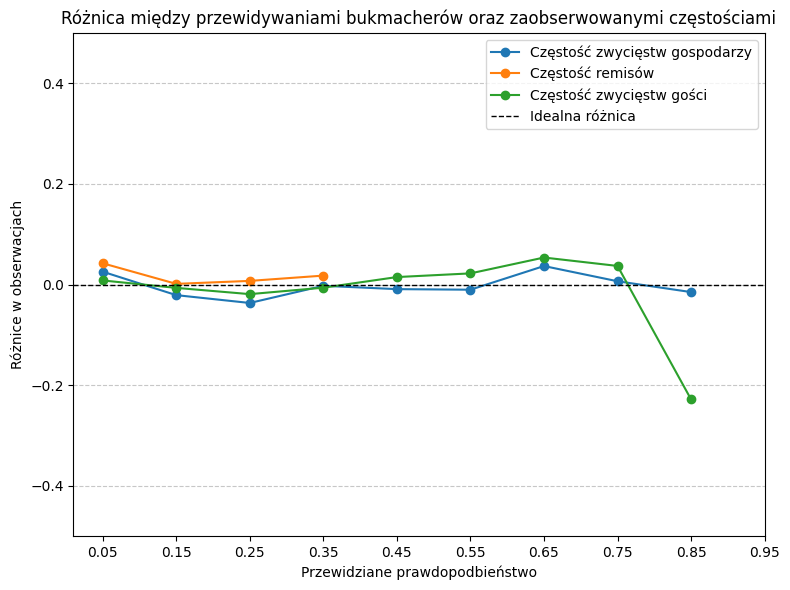

In [24]:
plt.figure(figsize=(8, 6))
bar_width = 0.03
plt.plot([float(x) + 0.05 for x in calibration_home_win["bin_home_win"]], calibration_home_win["difference"], marker="o", label="Częstość zwycięstw gospodarzy")
plt.plot([float(x) + 0.05 for x in calibration_draw["bin_draw"]], calibration_draw["difference"], marker="o", label="Częstość remisów")
plt.plot([float(x) + 0.05 for x in calibration_away_win["bin_away_win"]], calibration_away_win["difference"], marker="o", label="Częstość zwycięstw gości")
plt.axhline(0, color='k', linestyle='--', linewidth=1, label="Idealna różnica")
plt.xlabel("Przewidziane prawdopodbieństwo")
plt.ylabel("Różnice w obserwacjach")
plt.title("Różnica między przewidywaniami bukmacherów oraz zaobserwowanymi częstościami")
plt.xticks([float(x) + 0.05 for x in calibration_home_win["bin_home_win"]])
plt.ylim(-0.5, 0.5)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

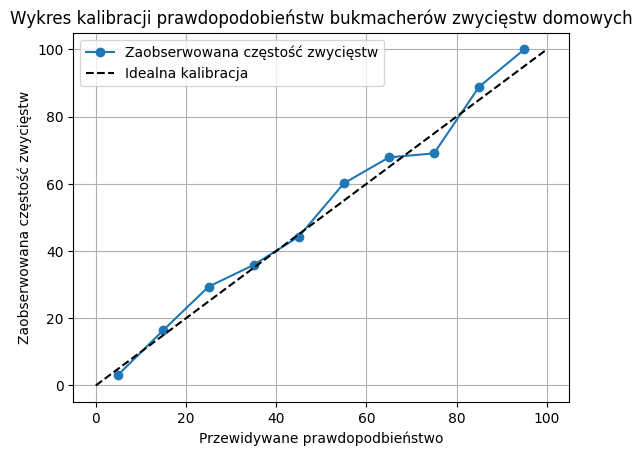

In [121]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results1.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów zwycięstw domowych")
plt.legend()
plt.grid()
plt.show()

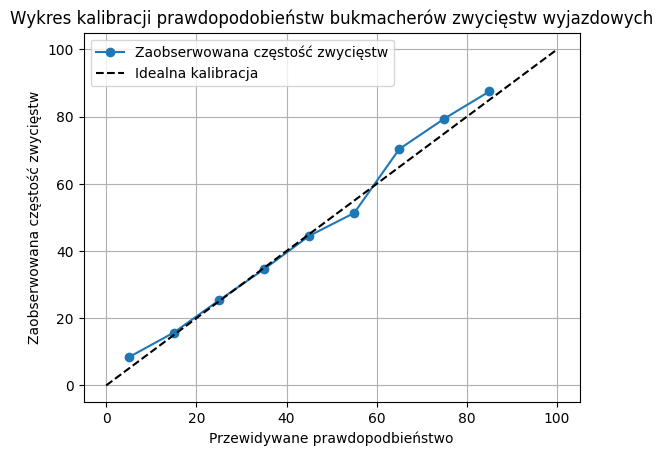

In [112]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results2.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość zwycięstw")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość zwycięstw")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów zwycięstw wyjazdowych")
plt.legend()
plt.grid()
plt.show()

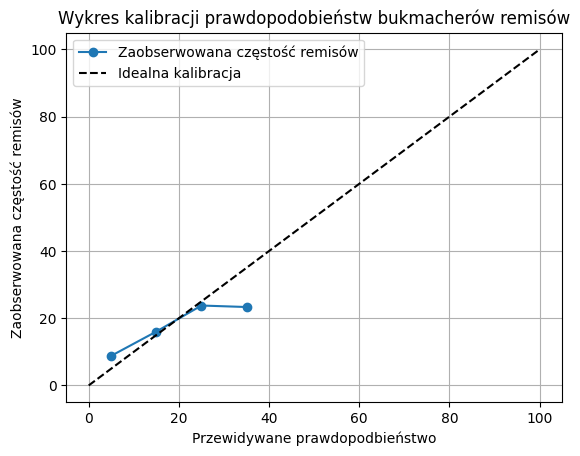

In [113]:
centers = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
values = bin_results0.values * 100

plt.plot(centers, values, "o-", label="Zaobserwowana częstość remisów")
x = np.linspace(0, 100, 1000)
plt.plot(x, x, "k--", label="Idealna kalibracja")
plt.xlabel("Przewidywane prawdopodbieństwo")
plt.ylabel("Zaobserwowana częstość remisów")
plt.title("Wykres kalibracji prawdopodobieństw bukmacherów remisów")
plt.legend()
plt.grid()
plt.show()